<a href="https://www.kaggle.com/code/busrakamalrafa/deep-brain-tumor-detection?scriptVersionId=242683819" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install -q efficientnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.8 MB/s eta 0:00:00


In [2]:
import os
import sys
import cv2
import math
import umap
import shutil
import random
import imutils
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import efficientnet.tfkeras as efn

from tqdm import tqdm
from PIL import Image
from os import listdir

from tensorflow.keras import layers
from plotly import tools
from random import shuffle
from itertools import chain
from numpy import expand_dims
from matplotlib import pyplot
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input
from collections import Counter
from os.path import isfile, join
from sklearn.manifold import TSNE
from skimage.transform import resize
from skimage.morphology import label
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from IPython.display import clear_output
from sklearn.metrics import recall_score
from sklearn.datasets import make_circles
from sklearn.metrics import roc_auc_score
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.metrics import precision_score
from tensorflow.keras.layers import Dropout, Lambda
from sklearn.metrics import cohen_kappa_score
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from plotly.offline import init_notebook_mode, iplot
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, confusion_matrix,ConfusionMatrixDisplay
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from skimage.io import imread, imshow, imread_collection, concatenate_images
import tensorflow.keras.layers as L

2025-05-30 07:16:46.873227: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748589407.078649      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748589407.134773      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data Loading and split

In [3]:
random.seed(42)  # for reproducibility

IMG_PATH = '/kaggle/input/brain-tumor-detection'

# Clean old directories
for folder in ['TRAIN', 'VAL', 'TEST']:
    if os.path.exists(folder):
        shutil.rmtree(folder)

# Create new ones
for folder in ['TRAIN', 'VAL', 'TEST']:
    for label in ['YES', 'NO']:
        os.makedirs(os.path.join(folder, label), exist_ok=True)

# Shuffle and split for both classes
for CLASS in ['yes', 'no']:
    class_path = os.path.join(IMG_PATH, CLASS)
    IMG_FILES = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    
    random.shuffle(IMG_FILES)
    print(f'{len(IMG_FILES)} images found in class "{CLASS}"')

    for n, FILE_NAME in enumerate(IMG_FILES):
        src = os.path.join(class_path, FILE_NAME)
        if n < 200:
            dst = os.path.join('TEST', CLASS.upper(), FILE_NAME)
        elif n < 1200:
            dst = os.path.join('TRAIN', CLASS.upper(), FILE_NAME)
        else:
            dst = os.path.join('VAL', CLASS.upper(), FILE_NAME)
        
        shutil.copy(src, dst)


1500 images found in class "yes"
1500 images found in class "no"


In [4]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(os.path.join(dir_path, path)):
                if not file.startswith('.'):
                    img_path = os.path.join(dir_path, path, file)
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.resize(img, img_size)  
                        X.append(img)
                        y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels


In [5]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


2000 images loaded from TRAIN/ directory.


100%|██████████| 2/2 [00:00<00:00,  5.39it/s]


400 images loaded from TEST/ directory.


100%|██████████| 2/2 [00:00<00:00,  3.39it/s]

600 images loaded from VAL/ directory.


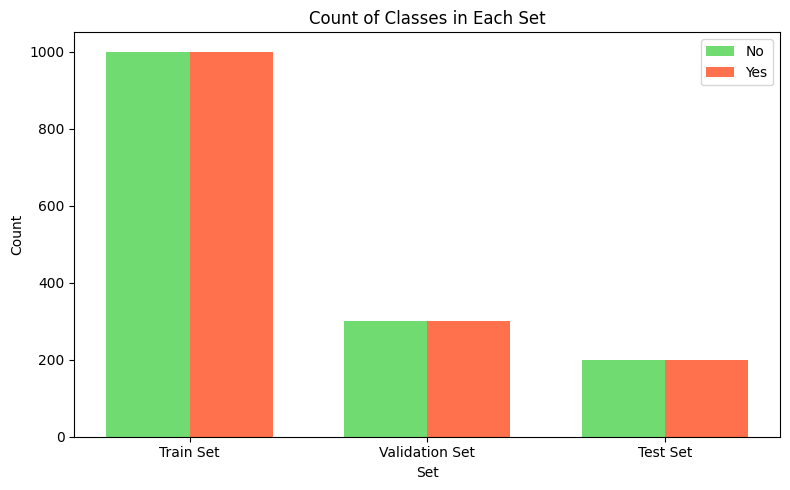

In [6]:
y = dict()
y[0] = []
y[1] = []

for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

set_labels = ['Train Set', 'Validation Set', 'Test Set']
x = np.arange(len(set_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bar1 = ax.bar(x - width/2, y[0], width, label='No', color='#33cc33', alpha=0.7)
bar2 = ax.bar(x + width/2, y[1], width, label='Yes', color='#ff3300', alpha=0.7)

# Labeling
ax.set_title('Count of Classes in Each Set')
ax.set_xlabel('Set')
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(set_labels)
ax.legend()

plt.tight_layout()
plt.show()


In [7]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,4))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

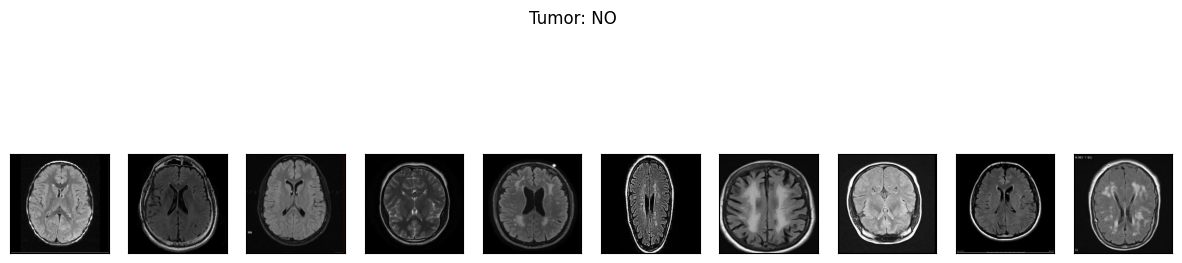

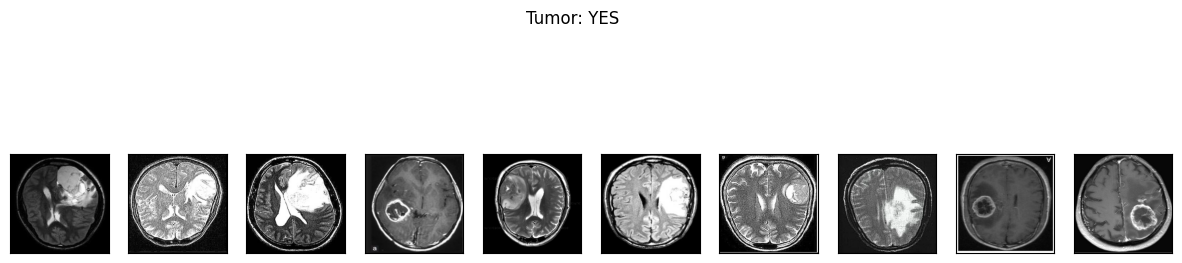

In [8]:
plot_samples(X_train, y_train, labels, 10)

# Data preprocessing

# normalization

In [9]:
def crop_imgs(set_name, add_pixels_value=0, resize_to=(224, 224)):
    """
    Crop around the extreme points of the image and resize to a fixed size.
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # Binary thresholding
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # Find contours
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)

        if len(cnts) == 0:
            set_new.append(cv2.resize(img, resize_to))  # fallback to resizing the full image
            continue

        c = max(cnts, key=cv2.contourArea)

        # Find extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        # Add pixels and crop
        ADD_PIXELS = add_pixels_value
        cropped = img[max(0, extTop[1] - ADD_PIXELS): extBot[1] + ADD_PIXELS,
                      max(0, extLeft[0] - ADD_PIXELS): extRight[0] + ADD_PIXELS]

        # Resize to fixed size
        resized = cv2.resize(cropped, resize_to)
        set_new.append(resized)
    
    return np.array(set_new)

In [10]:
img = cv2.imread('/kaggle/input/brain-tumor-detection/yes/y66.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

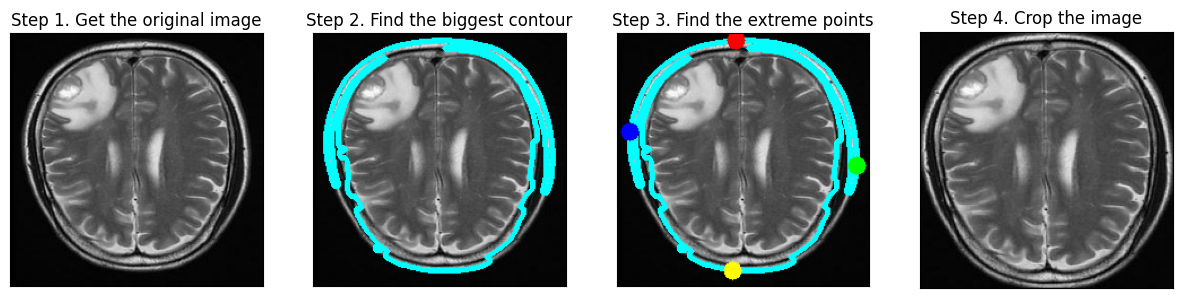

In [11]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [12]:
X_train_crop = crop_imgs(X_train)
X_val_crop = crop_imgs(X_val)
X_test_crop = crop_imgs(X_test)

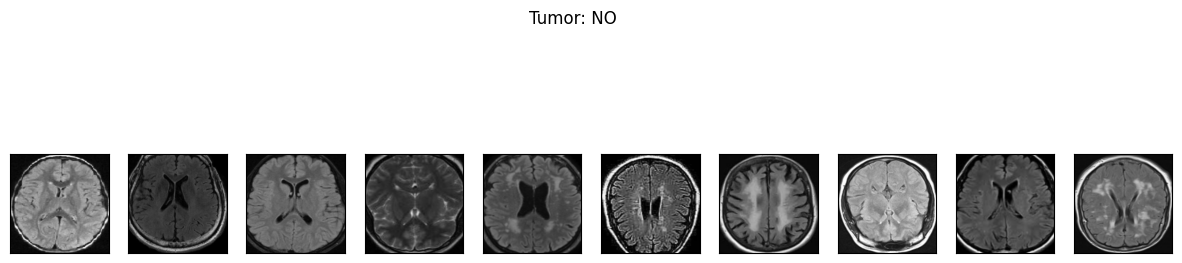

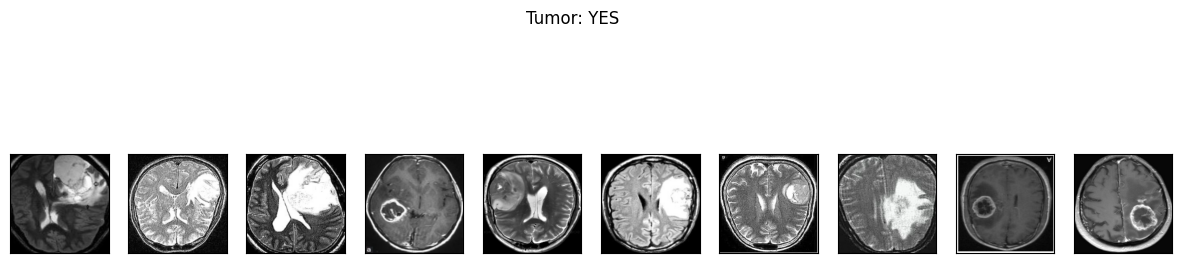

In [13]:
plot_samples(X_train_crop, y_train, labels, 10)

In [14]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [15]:
# saving new images to the folder
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

In [16]:
from tensorflow.keras.applications.vgg16 import preprocess_input

def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [17]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

# Augmentation

In [18]:
RANDOM_SEED = 42

TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=64,
    class_mode='binary',
    seed=RANDOM_SEED,
    shuffle=True
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 2000 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


# EfficientNetB2 Model

In [19]:
def build_lrfn(lr_start=0.0005, lr_max=0.001, 
               lr_min=0.000001, lr_rampup_epochs=20, 
               lr_sustain_epochs=0, lr_exp_decay=.8):
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr
    
    return lrfn

In [20]:
import tensorflow.keras.layers as L
NUM_CLASSES = 1

efficientnet = tf.keras.Sequential([
    efn.EfficientNetB2(
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False
    ),
    L.GlobalMaxPooling2D(),
    L.Dropout(rate=0.2),
    L.Dense(NUM_CLASSES, activation='sigmoid')
    ])
        
efficientnet.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy']
)
    
efficientnet.summary()

I0000 00:00:1748589477.170953      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


31936256/31936256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnet-b2 (Functional)         │ (None, 7, 7, 1408)          │       7,768,562 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 1408)                │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,409 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,769,971 (29.64 MB)

 Trainable params: 7,702,403 (29.38 MB)

 Non-trainable params: 67,568 (263.94 KB)

In [21]:
import time

start = time.time()

efficientnet_history = efficientnet.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=30,
)


end = time.time()
print(end - start)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/20


I0000 00:00:1748589557.009272      87 service.cc:148] XLA service 0x7a9e640021a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748589557.010128      87 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748589563.562974      87 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1748589576.768780      87 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748589576.966058      87 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748589577.555650      87 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748589577.7690

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - accuracy: 0.7929 - loss: 1.0336

E0000 00:00:1748589640.389849      85 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748589640.578064      85 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748589641.046940      85 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748589641.257043      85 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748589641.619490      85 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

32/32 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.7994 - loss: 1.0001 - val_accuracy: 0.8375 - val_loss: 0.7071
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 710ms/step - accuracy: 0.9774 - loss: 0.1005 - val_accuracy: 0.9500 - val_loss: 0.2836
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 702ms/step - accuracy: 0.9890 - loss: 0.0499 - val_accuracy: 0.9854 - val_loss: 0.2273
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 712ms/step - accuracy: 0.9943 - loss: 0.0270 - val_accuracy: 0.9917 - val_loss: 0.1743
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 683ms/step - accuracy: 0.9975 - loss: 0.0083 - val_accuracy: 0.9875 - val_loss: 0.2399
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 716ms/step - accuracy: 0.9977 - loss: 0.0060 - val_accuracy: 0.9896 - val_loss: 0.1747
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 707ms/step - accuracy: 0.9934 - loss: 0.0237 - val_accuracy: 0.9958 - val_loss: 0.0068
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 707ms/step - accuracy: 0.9867 - loss: 0.0428 - val_accuracy: 0.9917 

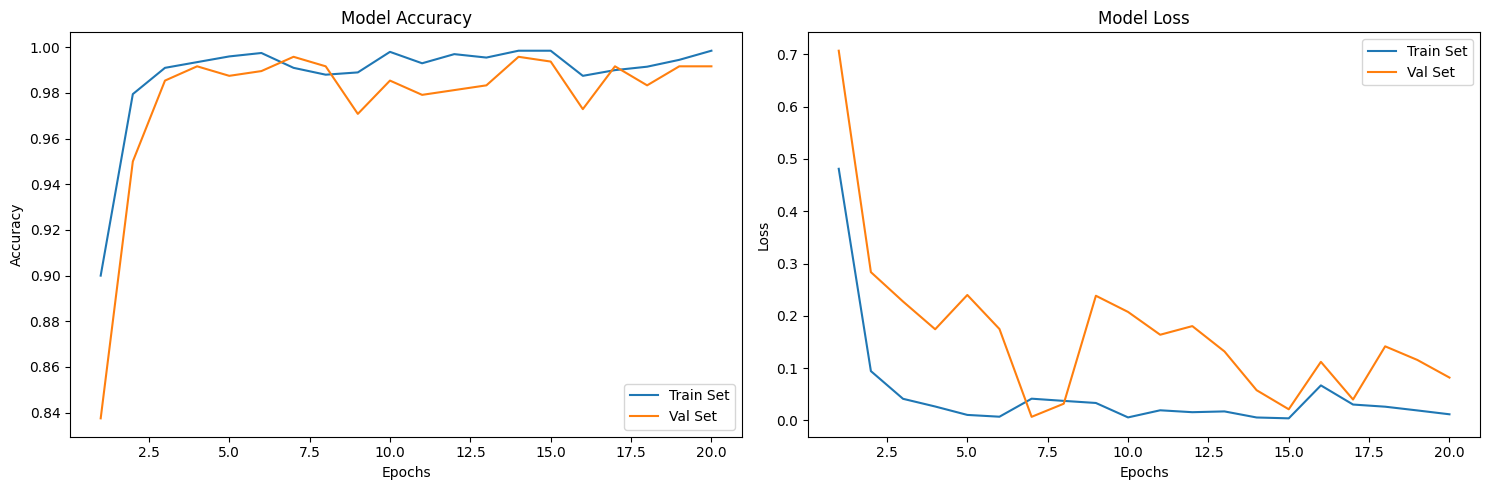

In [22]:
# plot model performance
acc = efficientnet_history.history['accuracy']
val_acc = efficientnet_history.history['val_accuracy']
loss = efficientnet_history.history['loss']
val_loss = efficientnet_history.history['val_loss']
epochs_range = range(1, len(efficientnet_history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

# model save

In [23]:
efficientnet.save('/kaggle/working/efficientnet_brain_tumor_model.h5')

# Load model

In [24]:
#efficientnet = load_model('/kaggle/input/efficientnet-brain-tumor-model/efficientnet_brain_tumor_model.h5')

19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 639ms/step
Validation Accuracy = 99.33


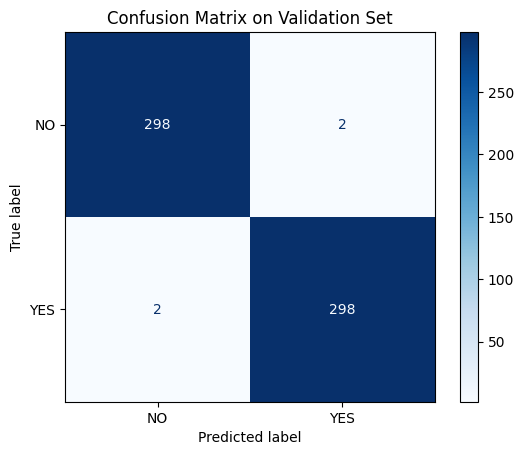

In [25]:
# validate on val set
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# Make predictions
predictions = efficientnet.predict(X_val_prep)
predictions = [1 if x > 0.5 else 0 for x in predictions]

# Calculate accuracy
accuracy = accuracy_score(y_val, predictions)
print('Validation Accuracy = %.2f' % (accuracy * 100))

# Confusion matrix
cm = confusion_matrix(y_val, predictions)

# If your 'labels' dictionary looks like {0: 'No Tumor', 1: 'Tumor'}, pass values:
labels_display = list(labels.values())  # e.g., ['No Tumor', 'Tumor']

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_display)
disp.plot(cmap=plt.cm.Blues, values_format='d')  # 'd' for integer values
plt.title("Confusion Matrix on Validation Set")
plt.grid(False)
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 343ms/step
Test Accuracy = 0.987500


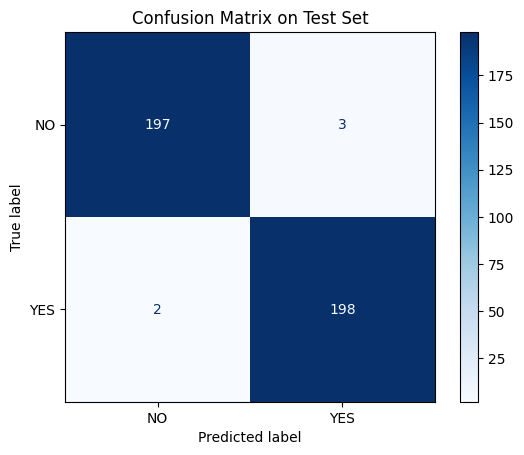

In [26]:
# validate on test set
predictions = efficientnet.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %2f' % accuracy)

# Confusion matrix
cm = confusion_matrix(y_test, predictions)

# If your 'labels' dictionary looks like {0: 'No Tumor', 1: 'Tumor'}, pass values:
labels_display = list(labels.values())  # e.g., ['No Tumor', 'Tumor']

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_display)
disp.plot(cmap=plt.cm.Blues, values_format='d')  # 'd' for integer values
plt.title("Confusion Matrix on Test Set")
plt.grid(False)
plt.show()

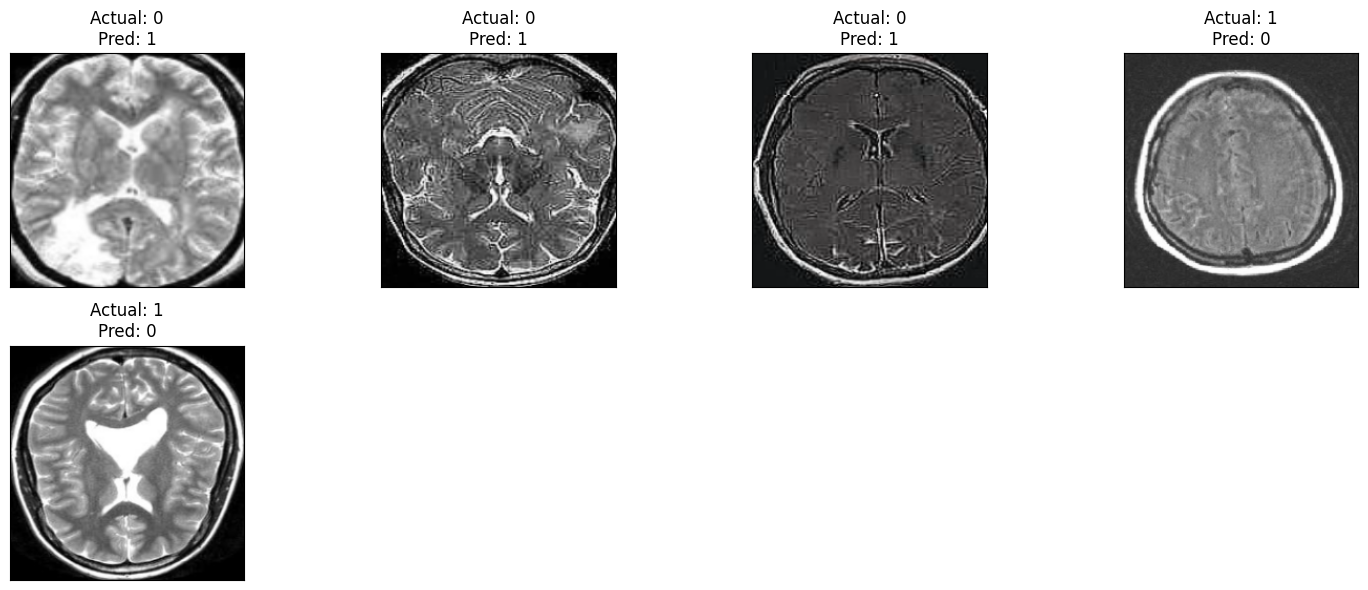

In [27]:
# Get indices of misclassified images
ind_list = np.argwhere((y_test == predictions) == False)[:, -1]

if ind_list.size == 0:
    print('There are no misclassified images.')
else:
    num_images = len(ind_list)
    cols = 4
    rows = (num_images + cols - 1) // cols  # Ceiling division to get row count

    plt.figure(figsize=(15, rows * 3))  # Adjust height as needed

    for idx, i in enumerate(ind_list):
        plt.subplot(rows, cols, idx + 1)
        plt.imshow(X_test_crop[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual: {y_test[i]}\nPred: {predictions[i]}')

    plt.tight_layout()
    plt.show()

# Densenet169

In [28]:
import tensorflow.keras.layers as L
from tensorflow.keras.applications import DenseNet169

NUM_CLASSES = 1

densenet = tf.keras.Sequential([
    DenseNet169(
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False
    ),
    L.GlobalMaxPooling2D(),
    L.Dropout(rate=0.2),
    L.Dense(NUM_CLASSES, activation='sigmoid')
])

densenet.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

densenet.summary()

51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet169 (Functional)             │ (None, 7, 7, 1664)          │      12,642,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d_1               │ (None, 1664)                │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1664)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           1,665 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,644,545 (48.24 MB)

 Trainable params: 12,486,145 (47.63 MB)

 Non-trainable params: 158,400 (618.75 KB)

In [29]:
import time

start = time.time()

densenet_history = densenet.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=30,
)


end = time.time()
print(end - start)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 445s 5s/step - accuracy: 0.7692 - loss: 0.9760 - val_accuracy: 0.6771 - val_loss: 13.6533
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 711ms/step - accuracy: 0.9571 - loss: 0.1554 - val_accuracy: 0.7708 - val_loss: 10.1265
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 714ms/step - accuracy: 0.9807 - loss: 0.0604 - val_accuracy: 0.9208 - val_loss: 0.5872
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 678ms/step - accuracy: 0.9741 - loss: 0.0790 - val_accuracy: 0.9312 - val_loss: 0.6922
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 697ms/step - accuracy: 0.9730 - loss: 0.0746 - val_accuracy: 0.9583 - val_loss: 0.2112
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 704ms/step - accuracy: 0.9848 - loss: 0.0530 - val_accuracy: 0.9792 - val_loss: 0.1298
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 713ms/step - accuracy: 0.9986 - loss: 0.0087 - val_accuracy: 0.9875 - val_loss: 0.0522
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 685ms/step - accuracy: 0.9973 - loss: 0.0097 - val_accu

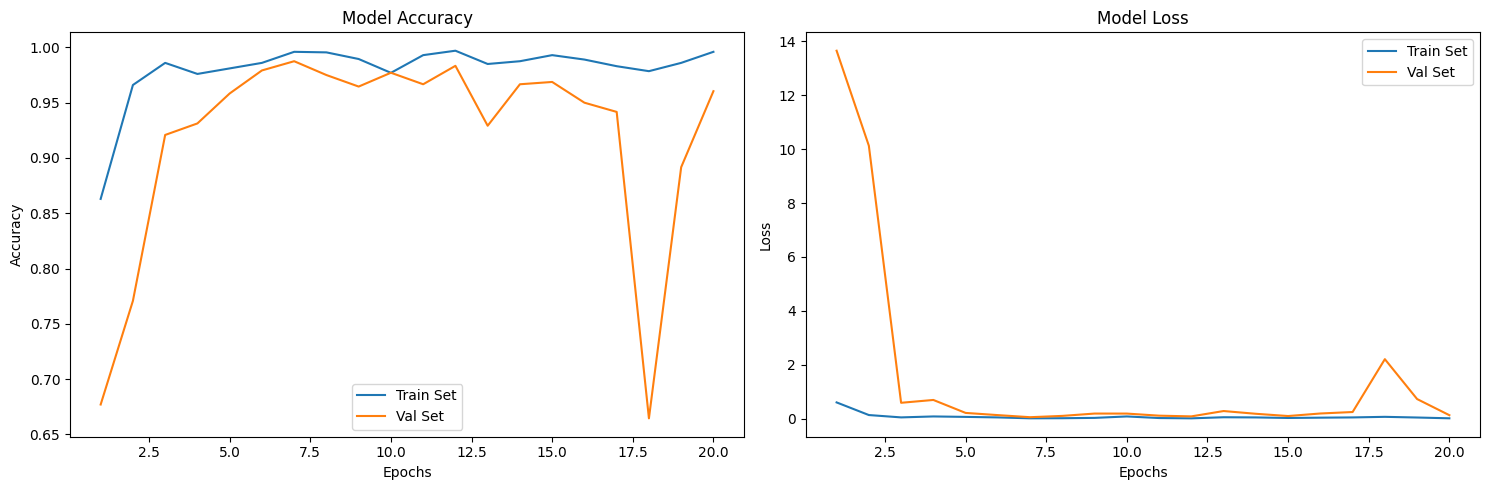

In [30]:
# plot model performance
acc = densenet_history.history['accuracy']
val_acc = densenet_history.history['val_accuracy']
loss = densenet_history.history['loss']
val_loss = densenet_history.history['val_loss']
epochs_range = range(1, len(densenet_history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

# model save

In [31]:
densenet.save('/kaggle/working/densenet169_brain_tumor_model.h5')

# load model

In [32]:
#densenet = load_model('/kaggle/input/densenet169-brain-tumor-model/densenet169_brain_tumor_model.h5')  # Replace with your actual path

19/19 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step
Validation Accuracy = 96.17%


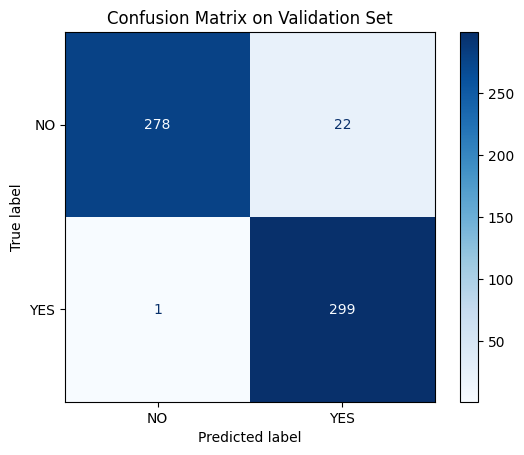

In [33]:
# validate on val set
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# Make predictions
predictions = densenet.predict(X_val_prep)
predictions = [1 if x > 0.5 else 0 for x in predictions]

# Calculate accuracy
accuracy = accuracy_score(y_val, predictions)
print('Validation Accuracy = %.2f%%' % (accuracy * 100))

# Confusion matrix
cm = confusion_matrix(y_val, predictions)

# If your 'labels' dictionary looks like {0: 'No Tumor', 1: 'Tumor'}, pass values:
labels_display = list(labels.values())  # e.g., ['No Tumor', 'Tumor']

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_display)
disp.plot(cmap=plt.cm.Blues, values_format='d')  # 'd' for integer values
plt.title("Confusion Matrix on Validation Set")
plt.grid(False)
plt.show()


13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 910ms/step
Test Accuracy = 0.97


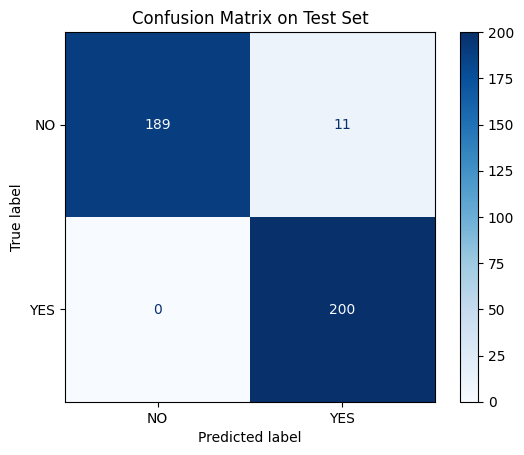

In [34]:
# validate on test set
predictions = densenet.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

# Confusion matrix
cm = confusion_matrix(y_test, predictions)

# If your 'labels' dictionary looks like {0: 'No Tumor', 1: 'Tumor'}, pass values:
labels_display = list(labels.values())  # e.g., ['No Tumor', 'Tumor']

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_display)
disp.plot(cmap=plt.cm.Blues, values_format='d')  # 'd' for integer values
plt.title("Confusion Matrix on Test Set")
plt.grid(False)
plt.show()



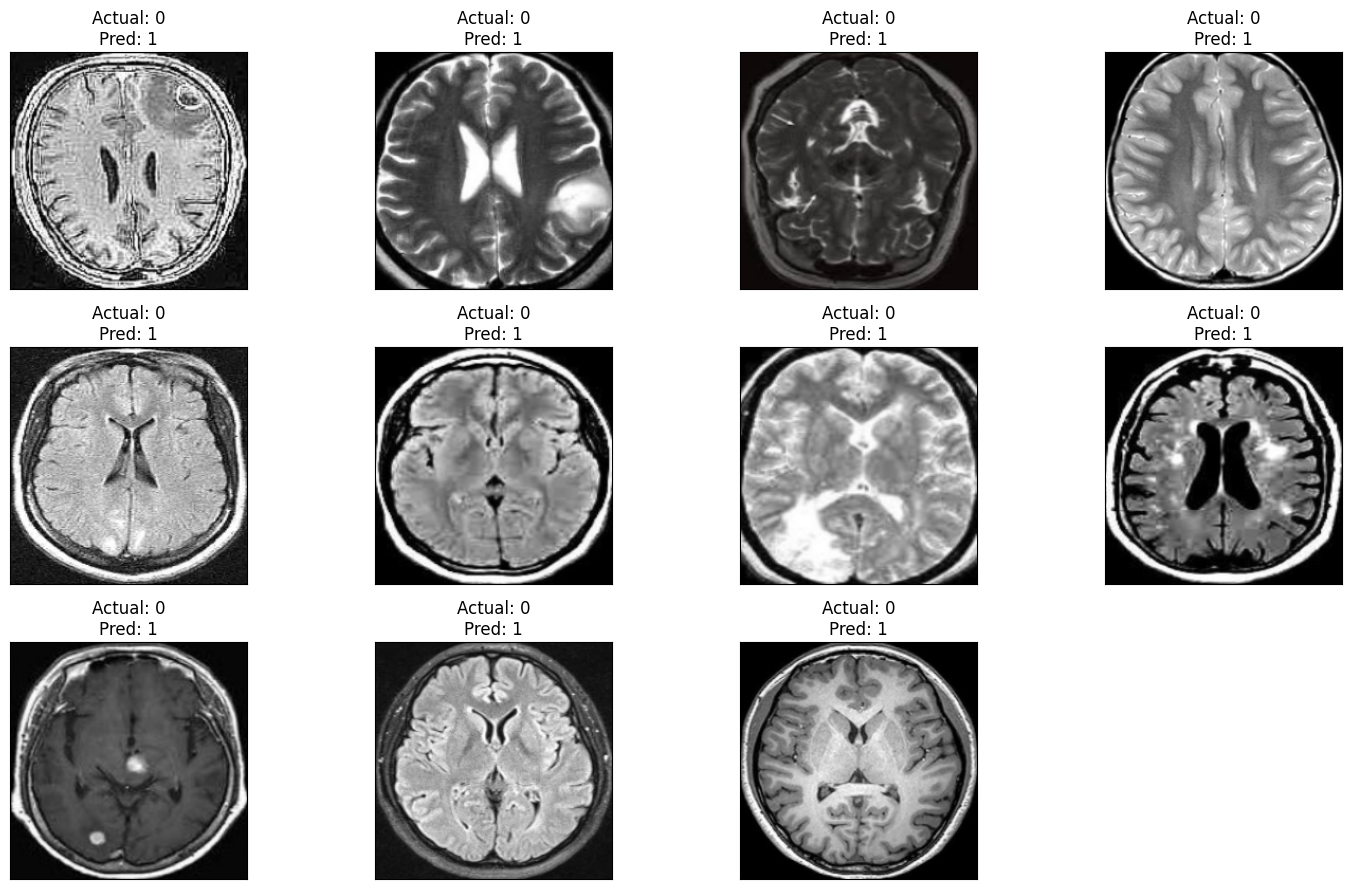

In [35]:
# Get indices of misclassified images
ind_list = np.argwhere((y_test == predictions) == False)[:, -1]

if ind_list.size == 0:
    print('There are no misclassified images.')
else:
    num_images = len(ind_list)
    cols = 4
    rows = (num_images + cols - 1) // cols  # Ceiling division to get row count

    plt.figure(figsize=(15, rows * 3))  # Adjust height as needed

    for idx, i in enumerate(ind_list):
        plt.subplot(rows, cols, idx + 1)
        plt.imshow(X_test_crop[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual: {y_test[i]}\nPred: {predictions[i]}')

    plt.tight_layout()
    plt.show()

# Xception Model

In [36]:
import tensorflow.keras.layers as L
from tensorflow.keras.applications import Xception

NUM_CLASSES = 1

xception = tf.keras.Sequential([
    Xception(
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False
    ),
    L.GlobalMaxPooling2D(),
    L.Dropout(rate=0.2),
    L.Dense(NUM_CLASSES, activation='sigmoid')
])

xception.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

xception.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 7, 7, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d_2               │ (None, 2048)                │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 20,809,001 (79.38 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [37]:
import time 

start = time.time()

xception_history = xception.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=30,
)

end = time.time()
print(end - start)

Epoch 1/20


E0000 00:00:1748591145.152970      87 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748591145.372436      87 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-30 07:45:46.912422: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[728,728,1,1]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,728,28,28]{3,2,1,0}, f32[64,728,28,28]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-05-30 07:45:46.931800: E exter

 8/32 ━━━━━━━━━━━━━━━━━━━━ 16s 691ms/step - accuracy: 0.6739 - loss: 0.6128

E0000 00:00:1748591171.790179      86 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748591171.987888      86 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748591172.699550      86 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748591172.884503      86 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748591173.489100      86 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

32/32 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.8204 - loss: 0.3836 - val_accuracy: 0.7479 - val_loss: 2.0131
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 732ms/step - accuracy: 0.9863 - loss: 0.0506 - val_accuracy: 0.9479 - val_loss: 0.6186
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 720ms/step - accuracy: 0.9914 - loss: 0.0281 - val_accuracy: 0.7750 - val_loss: 2.2038
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 761ms/step - accuracy: 0.9969 - loss: 0.0171 - val_accuracy: 0.9125 - val_loss: 0.8201
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 749ms/step - accuracy: 0.9927 - loss: 0.0219 - val_accuracy: 0.7771 - val_loss: 5.7438
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 740ms/step - accuracy: 0.9892 - loss: 0.0348 - val_accuracy: 0.9604 - val_loss: 0.1929
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 729ms/step - accuracy: 0.9976 - loss: 0.0125 - val_accuracy: 0.9833 - val_loss: 0.0888
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 728ms/step - accuracy: 0.9950 - loss: 0.0164 - val_accuracy: 0.9667 

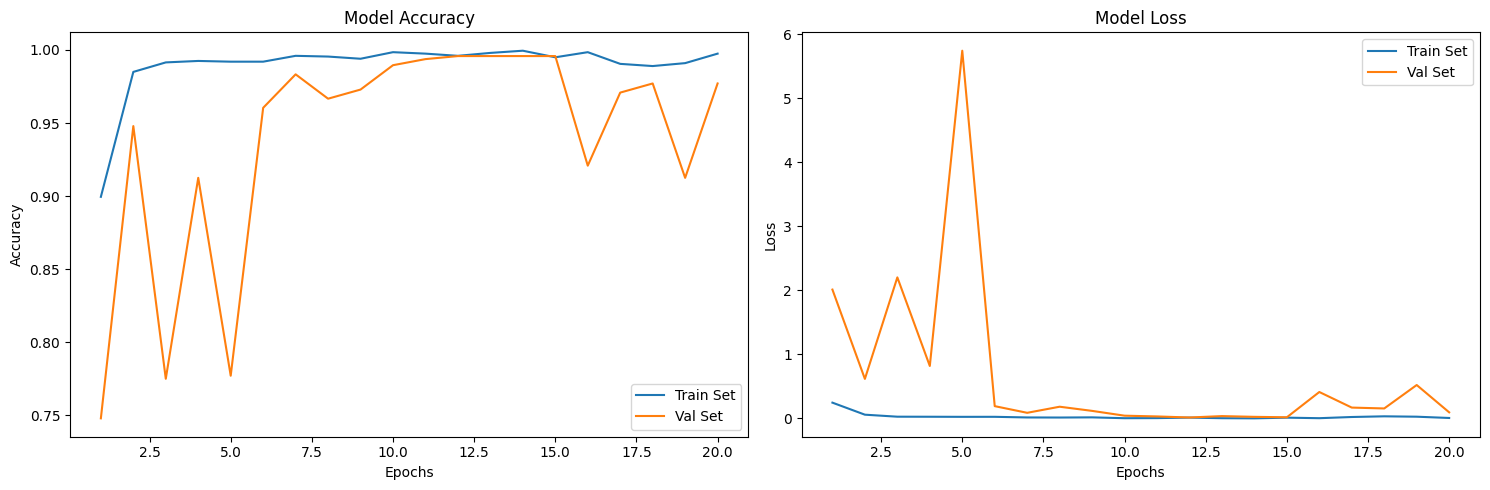

In [38]:
# plot model performance
acc = xception_history.history['accuracy']
val_acc = xception_history.history['val_accuracy']
loss = xception_history.history['loss']
val_loss = xception_history.history['val_loss']
epochs_range = range(1, len(xception_history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()


# Model save

In [39]:
xception.save('/kaggle/working/xception_brain_tumor_model.h5')

# Load model

In [40]:
#xception = load_model('/kaggle/input/xception-brain-tumor-model/xception_brain_tumor_model.h5') 

19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 324ms/step
Validation Accuracy = 97.17%


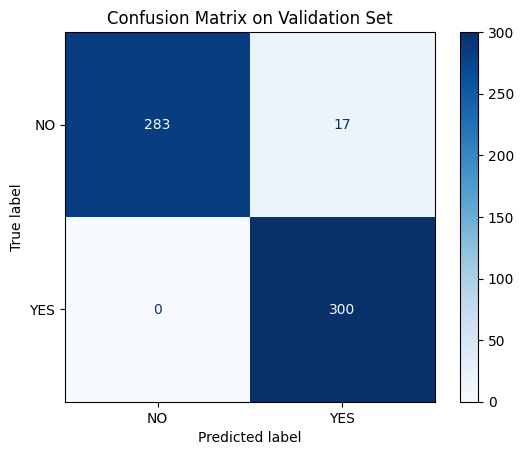

In [41]:
# validate on val set

# Make predictions
predictions = xception.predict(X_val_prep)
predictions = [1 if x > 0.5 else 0 for x in predictions]

# Calculate accuracy
accuracy = accuracy_score(y_val, predictions)
print('Validation Accuracy = %.2f%%' % (accuracy * 100))

# Confusion matrix
cm = confusion_matrix(y_val, predictions)

# If your 'labels' dictionary looks like {0: 'No Tumor', 1: 'Tumor'}, pass values:
labels_display = list(labels.values())  # e.g., ['No Tumor', 'Tumor']

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_display)
disp.plot(cmap=plt.cm.Blues, values_format='d')  # 'd' for integer values
plt.title("Confusion Matrix on Validation Set")
plt.grid(False)
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step
Test Accuracy = 0.98


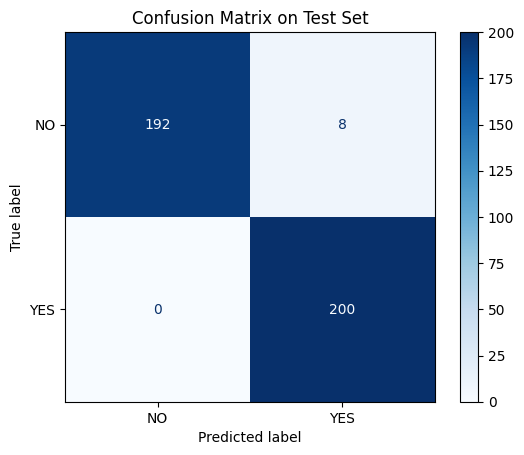

In [42]:
# validate on test set
predictions = xception.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

# Confusion matrix
cm = confusion_matrix(y_test, predictions)

# If your 'labels' dictionary looks like {0: 'No Tumor', 1: 'Tumor'}, pass values:
labels_display = list(labels.values())  # e.g., ['No Tumor', 'Tumor']

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_display)
disp.plot(cmap=plt.cm.Blues, values_format='d')  # 'd' for integer values
plt.title("Confusion Matrix on Test Set")
plt.grid(False)
plt.show()

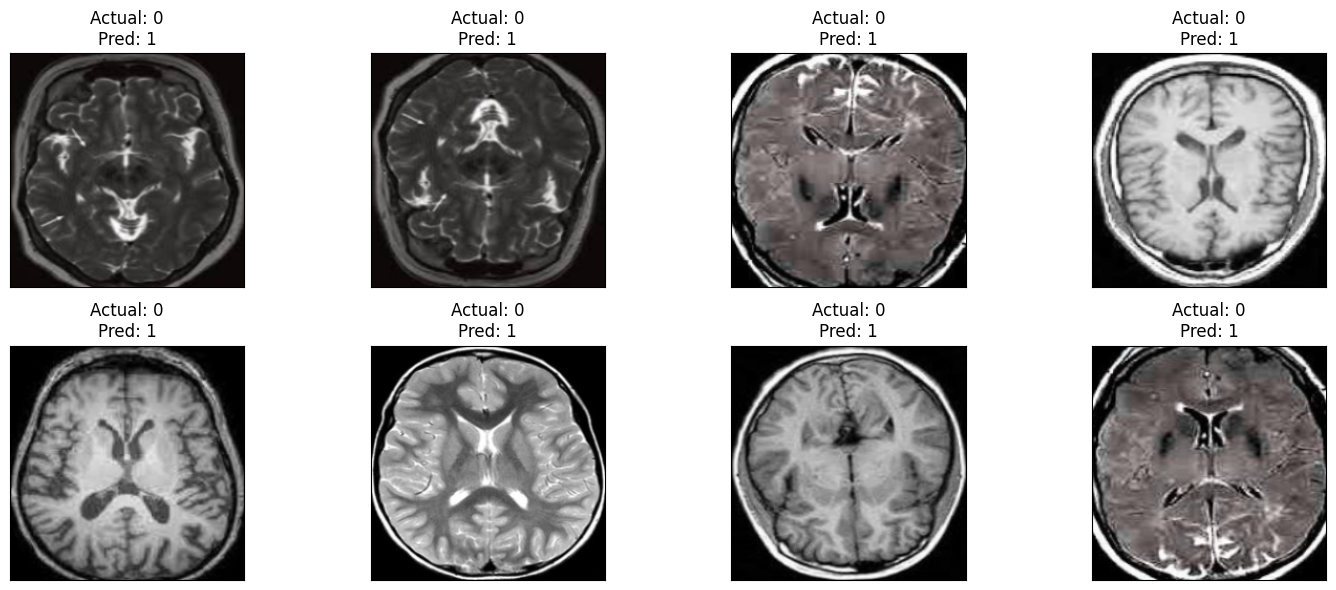

In [43]:
# Get indices of misclassified images
ind_list = np.argwhere((y_test == predictions) == False)[:, -1]

if ind_list.size == 0:
    print('There are no misclassified images.')
else:
    num_images = len(ind_list)
    cols = 4
    rows = (num_images + cols - 1) // cols  # Ceiling division to get row count

    plt.figure(figsize=(15, rows * 3))  # Adjust height as needed

    for idx, i in enumerate(ind_list):
        plt.subplot(rows, cols, idx + 1)
        plt.imshow(X_test_crop[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual: {y_test[i]}\nPred: {predictions[i]}')

    plt.tight_layout()
    plt.show()

# InceptionResNetV2 Model

In [44]:
from tensorflow.keras.applications import InceptionResNetV2

NUM_CLASSES = 1

inceptionresnet = tf.keras.Sequential([
    InceptionResNetV2(
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False
    ),
    L.GlobalMaxPooling2D(),
    L.Dropout(rate=0.2),
    L.Dense(NUM_CLASSES, activation='sigmoid')
])

inceptionresnet.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

inceptionresnet.summary()

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_resnet_v2 (Functional)     │ (None, 5, 5, 1536)          │      54,336,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d_3               │ (None, 1536)                │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │           1,537 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,338,273 (207.28 MB)

 Trainable params: 54,277,729 (207.05 MB)

 Non-trainable params: 60,544 (236.50 KB)

In [45]:
import time

start = time.time()

inceptionresnet_history = inceptionresnet.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=30,
)

end = time.time()
print(end - start)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 279s 3s/step - accuracy: 0.8027 - loss: 0.8279 - val_accuracy: 0.4917 - val_loss: 367.7486
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 723ms/step - accuracy: 0.9706 - loss: 0.0843 - val_accuracy: 0.9708 - val_loss: 0.1772
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 695ms/step - accuracy: 0.9928 - loss: 0.0233 - val_accuracy: 0.9854 - val_loss: 0.0633
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 727ms/step - accuracy: 0.9933 - loss: 0.0152 - val_accuracy: 0.9917 - val_loss: 0.0411
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 721ms/step - accuracy: 0.9824 - loss: 0.2265 - val_accuracy: 0.8500 - val_loss: 26.0670
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 719ms/step - accuracy: 0.9871 - loss: 0.1782 - val_accuracy: 0.7896 - val_loss: 0.6681
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 709ms/step - accuracy: 0.9845 - loss: 0.0421 - val_accuracy: 0.5854 - val_loss: 11.1780
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 734ms/step - accuracy: 0.9963 - loss: 0.0184 - val_ac

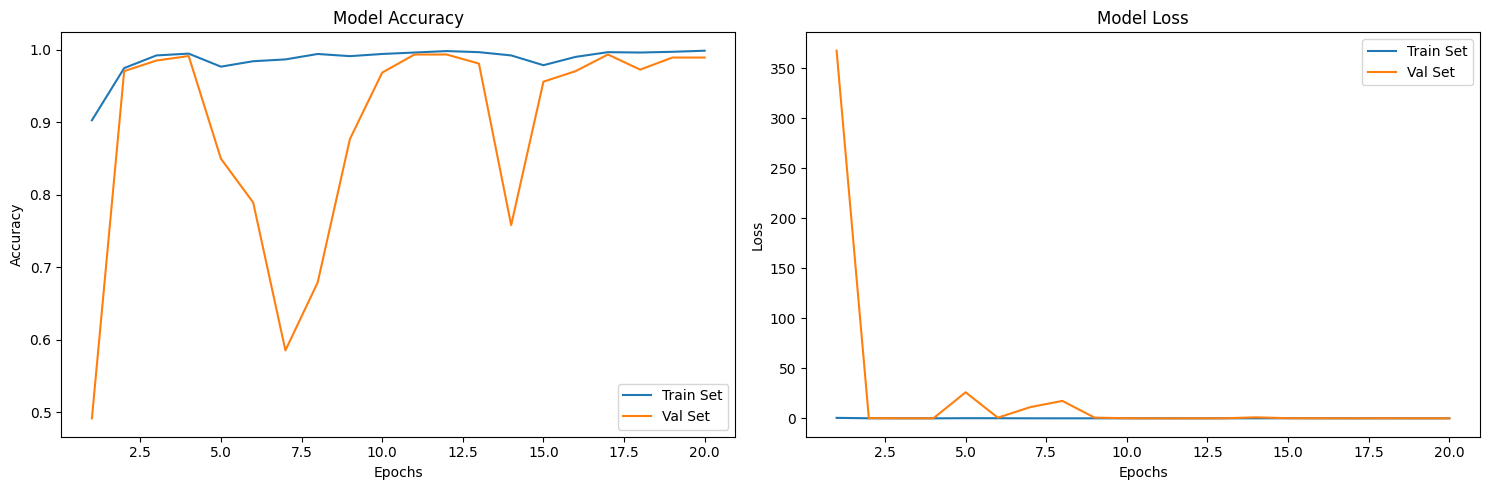

In [46]:
# plot model performance
acc = inceptionresnet_history.history['accuracy']
val_acc = inceptionresnet_history.history['val_accuracy']
loss = inceptionresnet_history.history['loss']
val_loss = inceptionresnet_history.history['val_loss']
epochs_range = range(1, len(inceptionresnet_history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

# model save

In [47]:
inceptionresnet.save('/kaggle/working/inceptionresnet_brain_tumor_model.h5')

# load model

In [48]:
#inceptionresnet = load_model('/kaggle/input/inceptionresnet-brain-tumor-model/inceptionresnet_brain_tumor_model.h5') 

19/19 ━━━━━━━━━━━━━━━━━━━━ 36s 899ms/step
Validation Accuracy = 99.166667


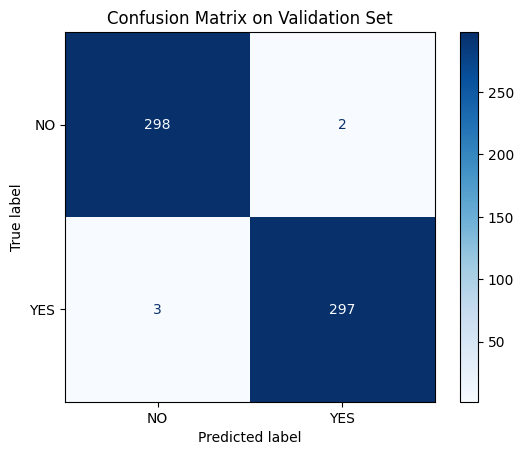

In [49]:
# validate on val set

# Make predictions
predictions = inceptionresnet.predict(X_val_prep)
predictions = [1 if x > 0.5 else 0 for x in predictions]

# Calculate accuracy
accuracy = accuracy_score(y_val, predictions)
print('Validation Accuracy = %2f' % (accuracy * 100))

# Confusion matrix
cm = confusion_matrix(y_val, predictions)

# If your 'labels' dictionary looks like {0: 'No Tumor', 1: 'Tumor'}, pass values:
labels_display = list(labels.values())  # e.g., ['No Tumor', 'Tumor']

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_display)
disp.plot(cmap=plt.cm.Blues, values_format='d')  # 'd' for integer values
plt.title("Confusion Matrix on Validation Set")
plt.grid(False)
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 434ms/step
Test Accuracy = 0.995000


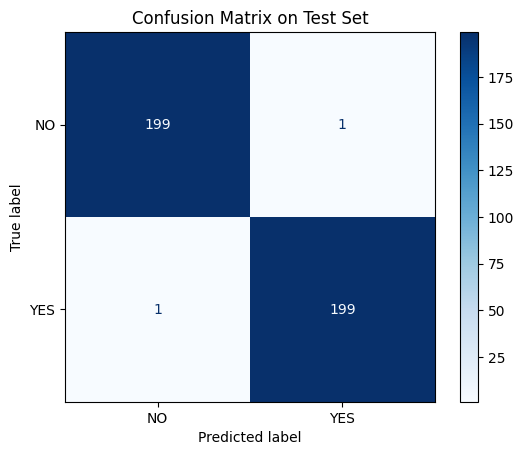

In [50]:
# validate on test set
predictions = inceptionresnet.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %2f' % accuracy)

# Confusion matrix
cm = confusion_matrix(y_test, predictions)

# If your 'labels' dictionary looks like {0: 'No Tumor', 1: 'Tumor'}, pass values:
labels_display = list(labels.values())  # e.g., ['No Tumor', 'Tumor']

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_display)
disp.plot(cmap=plt.cm.Blues, values_format='d')  # 'd' for integer values
plt.title("Confusion Matrix on Test Set")
plt.grid(False)
plt.show()

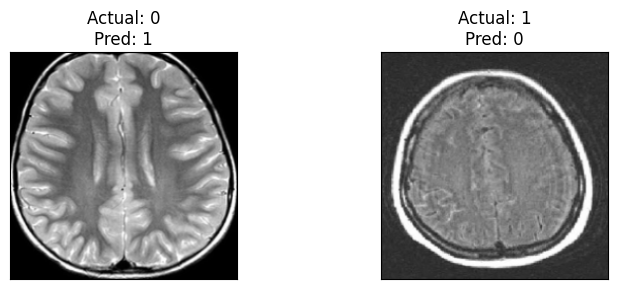

In [51]:
# Get indices of misclassified images
ind_list = np.argwhere((y_test == predictions) == False)[:, -1]

if ind_list.size == 0:
    print('There are no misclassified images.')
else:
    num_images = len(ind_list)
    cols = 4
    rows = (num_images + cols - 1) // cols  # Ceiling division to get row count

    plt.figure(figsize=(15, rows * 3))  # Adjust height as needed

    for idx, i in enumerate(ind_list):
        plt.subplot(rows, cols, idx + 1)
        plt.imshow(X_test_crop[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual: {y_test[i]}\nPred: {predictions[i]}')

    plt.tight_layout()
    plt.show()

# **Test single model**

# Single Image Prediction with EfficientNetB2

In [52]:
def Tumor_or_Not(x):
    return 'no' if x < 0.5 else 'yes'

image_path = '/kaggle/input/brain-tumor-detection/yes/y1013.jpg'
image = cv2.imread(image_path)
image = cv2.resize(image, (224, 224))
image = tf.expand_dims(image, axis=0)  # Add batch dimension

pred = efficientnet.predict(image)[0][0]
print(Tumor_or_Not(pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
yes


# Multiple Predictions from test_dataset with Visualization

In [53]:
TEST_DIR_predict = 'TEST_CROP/'

test_generator_predict = test_datagen.flow_from_directory(
    TEST_DIR_predict,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

Found 400 images belonging to 2 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


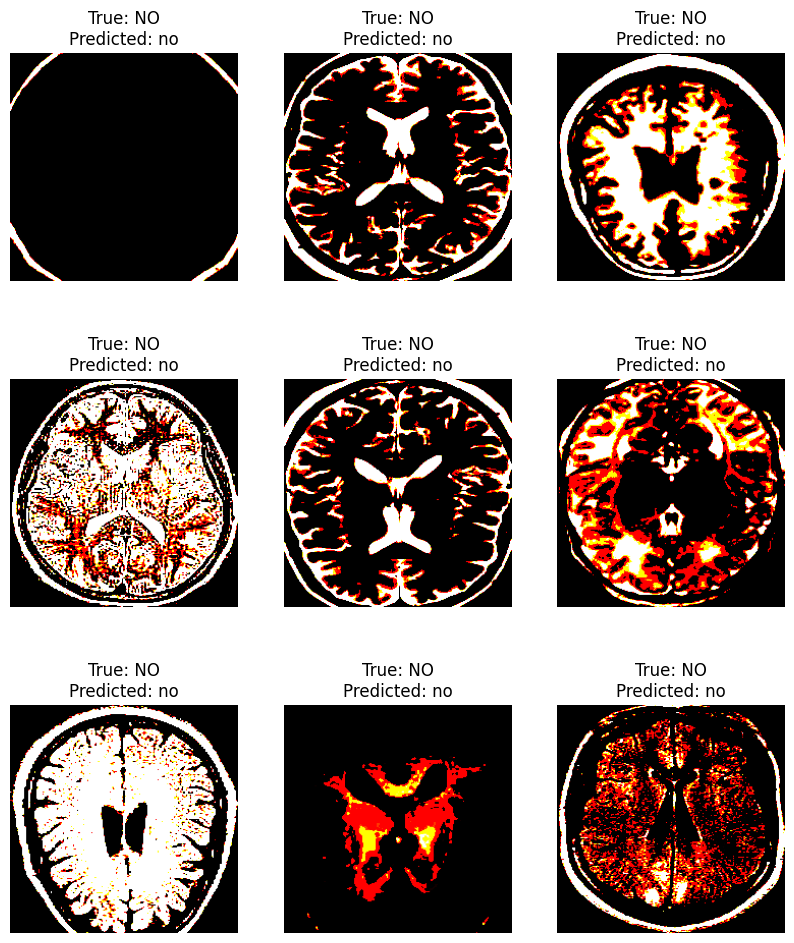

In [54]:
class_names = list(test_generator_predict.class_indices.keys())

plt.figure(figsize=(10, 12))

for i in range(9):
    image, label = test_generator_predict[i]  # (image.shape = (1, 224, 224, 3)), (label.shape = (1,))
    img = image[0]
    true_label = label[0]

    pred = efficientnet.predict(tf.expand_dims(img, axis=0))[0][0]

    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f"True: {class_names[int(true_label)]}\nPredicted: {Tumor_or_Not(pred)}")
    plt.axis('off')